In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math

In [45]:
fixingI_2019_df = pd.read_excel('data_2019.xlsx', usecols=['date', 'kurs fixingu I (PLN/MWh)'])

In [46]:
fixingI_2019_df

,kurs fixingu I (PLN/MWh),date
0,40.00,2019-01-02 01:00:00
1,31.00,2019-01-02 02:00:00
2,31.00,2019-01-02 03:00:00
3,31.00,2019-01-02 04:00:00
4,31.00,2019-01-02 05:00:00
...,...,...
8729,185.00,2019-12-31 19:00:00
8730,172.28,2019-12-31 20:00:00
8731,157.63,2019-12-31 21:00:00
8732,149.99,2019-12-31 22:00:00


## Model: Recurrent Neural Network LSTM and GRU

In [47]:
fixingI_2019 = fixingI_2019_df[['kurs fixingu I (PLN/MWh)']]
scaler = MinMaxScaler(feature_range=(-1, 1))
fixingI_2019['kurs fixingu I (PLN/MWh)'] = scaler.fit_transform(fixingI_2019['kurs fixingu I (PLN/MWh)'].values.reshape(-1,1))

C:\Users\Przem\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() 
    
    data = []
    
    
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = 24
    val_set_size = 24
    train_set_size = data.shape[0] - (test_set_size) - (val_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_val = data[:val_set_size,:-1]
    y_val = data[:val_set_size,-1,:]
    
    x_test = data[:train_set_size,:-1]
    y_test = data[:train_set_size,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

In [49]:
#Hyper-parametres
input_dim = 1
output_dim = 1
hidden_dim = 32
num_layers = 2
num_epochs = 80
sequence_length = 25
learning_rate = 0.05

In [50]:
x_train, y_train, x_val, y_val, x_test, y_test = split_data(fixingI_2019, sequence_length)

In [51]:
x_train = torch.from_numpy(x_train.astype(np.float32))
x_val = torch.from_numpy(x_val.astype(np.float32))
x_test = torch.from_numpy(x_test.astype(np.float32))

y_train_lstm = torch.from_numpy(y_train.astype(np.float32))
y_val_lstm = torch.from_numpy(y_val.astype(np.float32))
y_test_lstm = torch.from_numpy(y_test.astype(np.float32))

y_train_gru = torch.from_numpy(y_train.astype(np.float32))
y_val_gru = torch.from_numpy(y_val.astype(np.float32))
y_test_gru = torch.from_numpy(y_test.astype(np.float32))

In [52]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)     
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.rnn(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [53]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## The training loop

In [54]:
hist = np.zeros(num_epochs)

lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    
    
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()


Epoch  0 MSE:  0.07645082473754883
Epoch  1 MSE:  0.4278249442577362
Epoch  2 MSE:  0.08546724170446396
Epoch  3 MSE:  0.06487542390823364
Epoch  4 MSE:  0.03755948320031166
Epoch  5 MSE:  0.07361715286970139
Epoch  6 MSE:  0.03899180144071579
Epoch  7 MSE:  0.049017854034900665
Epoch  8 MSE:  0.049368876963853836
Epoch  9 MSE:  0.04608051851391792
Epoch  10 MSE:  0.05505327135324478
Epoch  11 MSE:  0.04357339069247246
Epoch  12 MSE:  0.03887737914919853
Epoch  13 MSE:  0.04371728375554085
Epoch  14 MSE:  0.0464271642267704
Epoch  15 MSE:  0.042436279356479645
Epoch  16 MSE:  0.03384045511484146
Epoch  17 MSE:  0.02690449357032776
Epoch  18 MSE:  0.025985127314925194
Epoch  19 MSE:  0.02754914201796055
Epoch  20 MSE:  0.022513961419463158
Epoch  21 MSE:  0.017444729804992676
Epoch  22 MSE:  0.01932167448103428
Epoch  23 MSE:  0.01981324516236782
Epoch  24 MSE:  0.014408409595489502
Epoch  25 MSE:  0.01570238545536995
Epoch  26 MSE:  0.01387625839561224
Epoch  27 MSE:  0.010635546408593

In [55]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

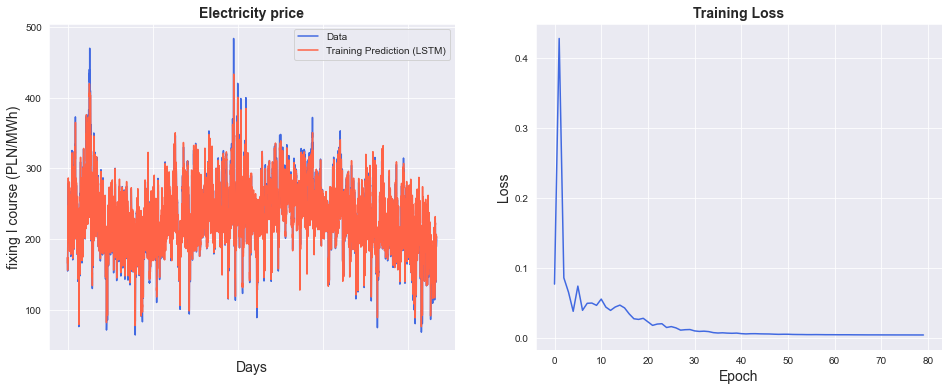

In [56]:
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Electricity price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("fixing I course (PLN/MWh)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
y_val_pred = model(x_val)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_val_pred = scaler.inverse_transform(y_val_pred.detach().numpy())
y_val = scaler.inverse_transform(y_val_lstm.detach().numpy())


In [61]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_val[:,0], y_val_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)


Train Score: 13.80 RMSE
Test Score: 11.01 RMSE


In [98]:
y_train

array([[173.56   ],
       [162.38   ],
       [154.51   ],
       ...,
       [202.68   ],
       [199.51   ],
       [189.15999]], dtype=float32)

In [68]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(fixingI_2019)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[sequence_length:len(y_train_pred)+sequence_length, :] = y_train_preda

In [84]:
# shift test predictions for plotting
valPredictPlot = np.empty_like(fixingI_2019)
valPredictPlot[:, :] = np.nan
valPredictPlot[len(y_train_pred)+sequence_length-1:len(fixingI_2019)-sequence_length, :] = y_val_pred

In [88]:
original = scaler.inverse_transform(fixingI_2019['kurs fixingu I (PLN/MWh)'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, valPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [89]:
result

,0,1,2
0,NaN,NaN,40.00
1,NaN,NaN,31.00
2,NaN,NaN,31.00
3,NaN,NaN,31.00
4,NaN,NaN,31.00
...,...,...,...
8729,NaN,NaN,185.00
8730,NaN,NaN,172.28
8731,NaN,NaN,157.63
8732,NaN,NaN,149.99


In [90]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Val prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (PLN)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [ ]:
plt.savefig('filename.png', dpi=300)

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)     
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.rnn(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
hist = np.zeros(num_epochs)

lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    
    
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()


In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(fixingI_2019)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[sequence_length:len(y_train_pred)+sequence_length, :] = y_train_preda

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Val prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (PLN)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()